In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import random
import copy
from imgaug import augmenters as iaa
import cv2
import tensorflow as tf
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D,  MaxPooling2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


Extract Data

In [3]:
def get_image_name_only(filePath):
    return filePath.split('\\')[-1]


def read_data(path):
    columns = ['Center', 'Left', 'Right', 'Steer', 'Gas', 'Brake', 'Speed']
    data = pd.read_csv(os.path.join(path, 'driving_log.csv'), names=columns)
    print(get_image_name_only(data['Center'][0]))
    data['Center'] = data['Center'].apply(get_image_name_only)
    data['Left'] = data['Left'].apply(get_image_name_only)
    data['Right'] = data['Right'].apply(get_image_name_only)
    print('Total Images Imported', data.shape[0])
    return data

def balance_data(original_data, display=True):
    data = original_data
    nBin = 25
    samplesPerBin = 450
    hist, bins = np.histogram(original_data['Steer'], nBin)
    if display:
        center = (bins[:-1] + bins[1:]) * 0.5
        plt.subplot(121), plt.bar(center, hist, width=0.06, color='red'), plt.subplots_adjust(wspace=0.5)
        plt.plot((np.min(original_data['Steer']), np.max(original_data['Steer'])), (samplesPerBin, samplesPerBin))
        plt.xlabel("Steering Angle(normalised)")
        plt.ylabel("Number of images")
        plt.title('Total images')
    removeindexList = []
    for j in range(nBin):
        binDataList = []
        for i in range(len(original_data['Steer'])):
            if original_data['Steer'][i] >= bins[j] and original_data['Steer'][i] <= bins[j + 1]:
                binDataList.append(i)
        binDataList = shuffle(binDataList)
        binDataList = binDataList[samplesPerBin:]
        removeindexList.extend(binDataList)

    print('Removed Images:', len(removeindexList))
    data.drop(data.index[removeindexList], inplace=True)
    print('Remaining Images:', len(data))
    if display:
        hist, _ = np.histogram(data['Steer'], (nBin))
        plt.subplot(122), plt.bar(center, hist, width=0.06, color='blue')
        plt.plot((np.min(data['Steer']), np.max(data['Steer'])), (samplesPerBin, samplesPerBin))
        plt.title('Reduced images')
        plt.xlabel("Steering Angle(normalised)")
        plt.ylabel("Number of images")
        plt.show()
    return data


def group_data(path, data):
    imageList = []
    steeringList = []
    throttleList = []
    speedList = []
    for i in data.index:
        imageList.append(cv2.imread(path +"/IMG/"+ data["Center"][i]))
        steeringList.append(data["Steer"][i])
        throttleList.append(data["Gas"][i] - data["Brake"][i])
        speedList.append(data["Speed"][i])
    return imageList, steeringList, throttleList, speedList

Image Augmentation

In [4]:
def image_augmentation(img, steering):
    if np.random.rand() > 0.5:
        pan = iaa.Affine(translate_percent={"x": (-0.05, 0.05), "y": (-0.05, 0.05)})
        img = pan.augment_image(img)
    if np.random.rand() > 0.5:
        brightness = iaa.Multiply((0.8, 1.2))
        img = brightness.augment_image(img)
    return img, steering


def image_preprocessing_aug(original_imageList, original_steeringList, display=True, data_multiplier=2):
    imageList = copy.deepcopy(original_imageList)
    steeringList = copy.deepcopy(original_steeringList)

    for i in range(data_multiplier):
        for j in range(len(original_imageList)):
            new_image, new_steering = image_augmentation(original_imageList[j], original_steeringList[j])
            if not new_image is None:
                imageList.append(new_image)
                steeringList.append(new_steering)

    print("Augmented image list size : ", len(imageList))
    print("Augmented steering list size : ", len(steeringList))
    if display:
        rand1 = random.randint(0, len(original_imageList) - 1)
        rand2 = random.randint(0, len(original_imageList) - 1)
        rand3 = random.randint(0, len(original_imageList) - 1)

        plt.figure()
        plt.subplot(331), plt.imshow(original_imageList[rand1])
        plt.title('original')
        plt.subplot(334), plt.imshow(imageList[len(original_imageList)+rand1])
        plt.title('augmented_1')
        plt.subplot(337), plt.imshow(imageList[len(original_imageList)*2+rand1])
        plt.title('augmented_2')

        plt.subplot(332), plt.imshow(original_imageList[rand2])
        plt.title('original')
        plt.subplot(335), plt.imshow(imageList[len(original_imageList)+rand2])
        plt.title('augmented_1')
        plt.subplot(338), plt.imshow(imageList[len(original_imageList)*2+rand2])
        plt.title('augmented_2')

        plt.subplot(333), plt.imshow(original_imageList[rand3])
        plt.title('original')
        plt.subplot(336), plt.imshow(imageList[len(original_imageList)+rand3])
        plt.title('augmented_1')
        plt.subplot(339), plt.imshow(imageList[len(original_imageList)*2+rand3])
        plt.title('augmented_2')

        print(steeringList[rand1],steeringList[rand2],steeringList[rand3])

    return imageList, steeringList

Feature Extraction and Image preprocessing

In [5]:
def feature_selection(image):
    image = image[60:135, :, :]  # Crop upper part
    # Resize the image to a consistent size
    image = cv2.resize(image, (200, 66))

    # Convert the image to the HSL color space
    hsl_image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)

    # Split the HSL image into H, L, and S channels
    h_channel, s_channel, l_channel = cv2.split(hsl_image)

    # Conditions
    # condition_1 = (100 < h_channel < 120) & (55 < s_channel < 80) & (25 < l_channel < 45)  Dark
    condition_1 = (90<h_channel)&(h_channel< 120) & ((s_channel-l_channel)>20) & ((s_channel-l_channel)<40) & (s_channel > 60)#(55<s_channel)&(s_channel<80) & (25<l_channel)&(l_channel<55)
    # condition_2 = (20 < h_channel < 40) & (s_channel > 200) | (l_channel > 200)   Bright
    condition_2 = (15<h_channel)&(h_channel<40) & ((((s_channel-l_channel)>175) & ((s_channel-l_channel)<220)) | ((s_channel>200)&(l_channel>100)))#| (l_channel > 220)

    # Create a binary mask by combining the two conditions using logical OR
    combined_mask = np.logical_or(condition_1, condition_2).astype(np.uint8) * 255

    # Convert the binary mask to 3 channels for merging with the original image
    binary_image = cv2.merge((combined_mask, combined_mask, combined_mask))

    # Reduce the saturation and lightness of original image
    s_channel = s_channel * 0.8
    l_channel = l_channel * 0.6


    reduced_image = cv2.merge((h_channel.astype(np.uint8), s_channel.astype(np.uint8), l_channel.astype(np.uint8)))

    # Apply bitwise_and to keep only the white lane lines
    white_lane_image = cv2.bitwise_or(reduced_image, binary_image)

    # Convert the image to grayscale
    gray = cv2.cvtColor(white_lane_image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # expand image dimension
    expand = np.expand_dims(blurred, axis=2)

    # Normalize pixel values to [0, 1]
    normalized = expand / 255.0

    return normalized


def image_preprocessing_feat(original_imageList, original_steeringList, display=True):
    imageList = copy.deepcopy(original_imageList)
    steeringList = original_steeringList

    for i in range(len(imageList)):
        imageList[i] = feature_selection(imageList[i])

    if display:
        rand1 = random.randint(0, len(original_imageList) - 1)
        rand2 = random.randint(0, len(original_imageList) - 1)
        rand3 = random.randint(0, len(original_imageList) - 1)
        plt.figure()
        plt.subplot(231), plt.imshow(original_imageList[rand1], interpolation='nearest')
        plt.title('original')
        plt.subplot(234), plt.imshow(imageList[rand1])
        plt.title('processed')

        plt.subplot(232), plt.imshow(original_imageList[rand2])
        plt.title('original')
        plt.subplot(235), plt.imshow(imageList[rand2])
        plt.title('processed')

        plt.subplot(233), plt.imshow(original_imageList[rand3])
        plt.title('original')
        plt.subplot(236), plt.imshow(imageList[rand3])
        plt.title('processed')

        print(steeringList[rand1],steeringList[rand2],steeringList[rand3])

    return imageList, steeringList

Model Creation and Training

In [6]:
def batch_generator(feat_imageList, feat_steeringList, batch_size):
    while True:
        batch_img = []
        batch_steering = []

        for i in range(batch_size):
            random_index = random.randint(0, len(feat_imageList) - 1)

            image = feat_imageList[random_index]
            steering = feat_steeringList[random_index]

            batch_img.append(image)
            batch_steering.append(steering)

        yield (np.asarray(batch_img), np.asarray(batch_steering))


def create_comma_ai_model():
    model = Sequential()

    model.add(Convolution2D(16, (8, 8), strides=(4, 4), padding="same", activation='elu', input_shape=(66, 200, 1)))
    model.add(Convolution2D(32, (5, 5), strides=(2, 2), padding="same", activation='elu'))
    model.add(Convolution2D(64, (5, 5), strides=(2, 2), padding="same", activation='elu'))

    model.add(Flatten())
    model.add(Dense(512, activation='elu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))

    model.compile(Adam(lr=0.0001), loss='mse', metrics=['mae'])

    return model


# Nvidia's CNN model for self-driving cars
def create_nvidia_model():
    model = Sequential()

    model.add(Convolution2D(24, (5, 5), (2, 2), input_shape=(66, 200, 1), activation='elu'))
    model.add(Convolution2D(36, (5, 5), (2, 2), activation='elu'))
    model.add(Convolution2D(48, (5, 5), (2, 2), activation='elu'))
    model.add(Convolution2D(64, (3, 3), activation='elu'))
    model.add(Convolution2D(64, (3, 3), activation='elu'))

    model.add(Flatten())
    model.add(Dense(100, activation='elu'))
    model.add(Dense(50, activation='elu'))
    model.add(Dense(10, activation='elu'))
    model.add(Dense(1))

    model.compile(Adam(lr=0.0001), loss='mse', metrics=['mae'])
    return model


def run_training(imageList, steeringList, display=True, model_type="Nvidia"):
    X_train, X_test, y_train, y_test = train_test_split(imageList, steeringList, test_size=0.2, random_state=2)
    print("Training set size: ", len(X_train))
    print("Testing set size: ", len(X_test))
    print("Training size: ", X_train[0].shape)


    if model_type == "Nvidia":
        model = create_nvidia_model()
    elif model_type == "comma_ai":
        model = create_comma_ai_model()

    if display:
        print(model.summary())

    training_history  = model.fit(batch_generator(X_train, y_train, 128),
                                  steps_per_epoch=300,
                                  epochs=25,
                                  validation_data=batch_generator(X_test, y_test, 128),
                                  validation_steps=200,
                                  verbose=1,
                                  shuffle=1,
                                  )

    model.save('model.h5')

    return training_history
    # validation_loss, validation_accuracy = model.evaluate_generator((batch_generator(X_test, y_test, 100)), verbose=1)
    # # Print loss and accuracy
    # print('Validation loss:', validation_loss)
    # print('Validation accuracy:', validation_accuracy)

def print_training_result(training_history, display = True):
    if display:
        plt.figure()
        plt.subplot(121),
        plt.plot(training_history .history['loss']),
        plt.plot(training_history .history['val_loss'])
        plt.legend(['training', 'validation'])
        plt.title('Loss')
        plt.xlabel('Epoch')

        print(training_history.history.keys())
        plt.subplot(122),
        plt.plot(training_history .history['mae']),
        plt.plot(training_history .history['val_mae'])
        plt.legend(['training', 'validation'])
        plt.title('MAE')
        plt.xlabel('Epoch')
        plt.show()


Read Data

center_2023_07_11_19_01_55_508.jpg
Total Images Imported 4355
Removed Images: 0
Remaining Images: 4355


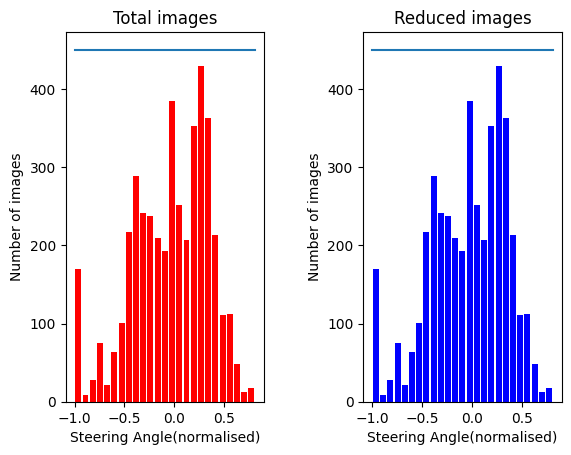

In [7]:
images_folder_name = 'Driving_data_mouse'           #Replace with your driving data folder name
full_data = read_data(images_folder_name)
reduced_data = balance_data(full_data, True)
#print(reduced_data.shape)


Augmented image list size :  13065
Augmented steering list size :  13065
0.2406015 -0.3157895 -0.01879699


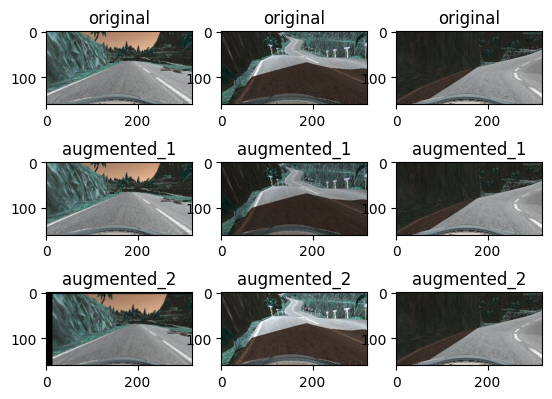

In [8]:
image_list, steering_list, throttle_list, speed_list = group_data(images_folder_name, reduced_data)
aug_image_list, aug_steering_list = image_preprocessing_aug(image_list, steering_list, True)


0.3233083 -0.3007519 0.5225564


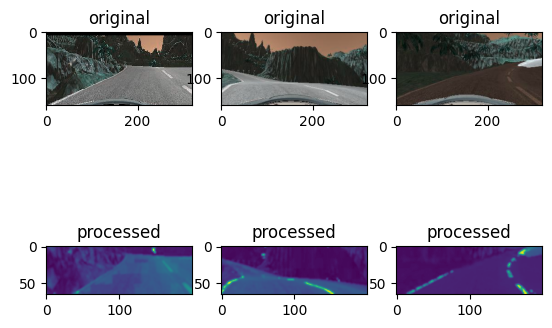

In [9]:
feat_image_list, feat_steering_list = image_preprocessing_feat(aug_image_list, aug_steering_list, True)


In [10]:
def feature_selection(img):
    img = img[60:135, 10:, :]
    # img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img, (3, 3), 0)
    img = cv2.resize(img, (200, 66))
    img = img / 255
    return img


In [11]:
result = run_training(feat_image_list, feat_steering_list, True)

Training set size:  10452
Testing set size:  2613
Training size:  (66, 200, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 31, 98, 24)        624       
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 47, 36)        21636     
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 22, 48)         43248     
                                                                 
 conv2d_3 (Conv2D)           (None, 3, 20, 64)         27712     
                                                                 
 conv2d_4 (Conv2D)           (None, 1, 18, 64)         36928     
                                                                 
 flatten (Flatten)           (None, 1152)              0         
                                           

300/300 [==============================] - 40s 131ms/step - loss: 0.0678 - mae: 0.1986 - val_loss: 0.0617 - val_mae: 0.1873
Epoch 2/25
300/300 [==============================] - 38s 127ms/step - loss: 0.0479 - mae: 0.1641 - val_loss: 0.0451 - val_mae: 0.1591
Epoch 3/25
300/300 [==============================] - 38s 127ms/step - loss: 0.0349 - mae: 0.1396 - val_loss: 0.0338 - val_mae: 0.1373
Epoch 4/25
300/300 [==============================] - 38s 126ms/step - loss: 0.0280 - mae: 0.1249 - val_loss: 0.0280 - val_mae: 0.1232
Epoch 5/25
300/300 [==============================] - 38s 126ms/step - loss: 0.0226 - mae: 0.1123 - val_loss: 0.0229 - val_mae: 0.1116
Epoch 6/25
300/300 [==============================] - 38s 126ms/step - loss: 0.0194 - mae: 0.1042 - val_loss: 0.0219 - val_mae: 0.1099
Epoch 7/25
300/300 [==============================] - 38s 126ms/step - loss: 0.0164 - mae: 0.0957 - val_loss: 0.0202 - val_mae: 0.1047
Epoch 8/25
300/300 [==============================] - 38s 127ms/st

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])


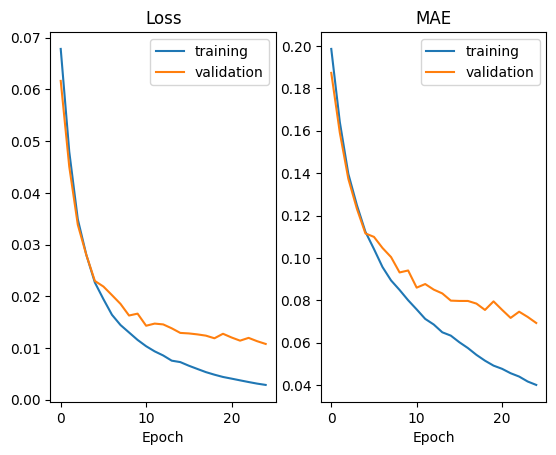

In [12]:
print_training_result(result, True)

In [13]:
def feature_selection(img):
    img = img[60:135, :, :]  # Crop upper part
    # Resize the image to a consistent size
    img = cv2.resize(img, (200, 66))
    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply histogram equalization
    equalized = cv2.equalizeHist(gray)
    # Apply adaptive thresholding to enhance lane visibility
    _, thresholded = cv2.threshold(equalized, 150, 255, cv2.THRESH_BINARY)
    # # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(thresholded, (3, 3), 0)
    # expand image dimension
    expand = np.expand_dims(blurred, axis=2)
    # Normalize pixel values to [0, 1]
    normalized = expand / 255.0
    return normalized

0.3496241 0.2218045 -0.7518798
Training set size:  10452
Testing set size:  2613
Training size:  (66, 200, 1)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 31, 98, 24)        624       
                                                                 
 conv2d_6 (Conv2D)           (None, 14, 47, 36)        21636     
                                                                 
 conv2d_7 (Conv2D)           (None, 5, 22, 48)         43248     
                                                                 
 conv2d_8 (Conv2D)           (None, 3, 20, 64)         27712     
                                                                 
 conv2d_9 (Conv2D)           (None, 1, 18, 64)         36928     
                                                                 
 flatten_1 (Flatten)         (None, 1152)              0         
          

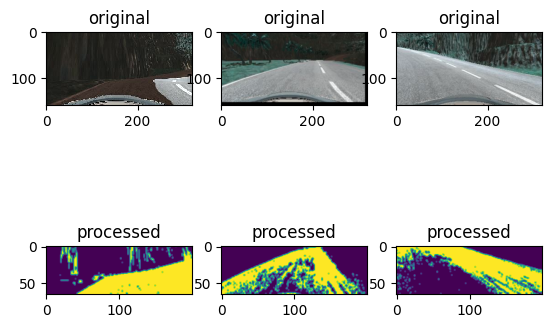

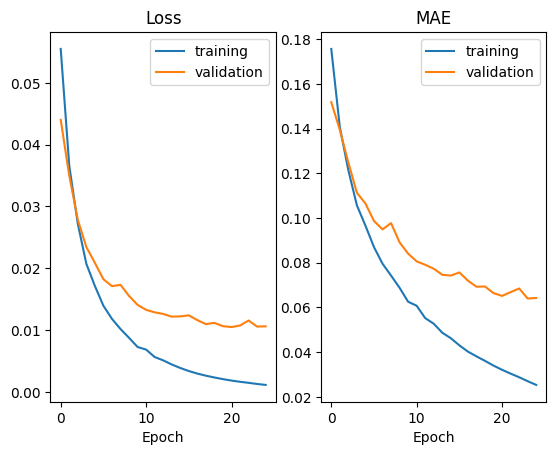

In [14]:
#thresholding
feat_image_list, feat_steering_list = image_preprocessing_feat(aug_image_list, aug_steering_list, True)
result_2 = run_training(feat_image_list, feat_steering_list, True)
print_training_result(result_2, True)

In [15]:
def feature_selection(img):
    img = img[60:135, :, :]  # Crop upper part
    # Resize the image to a consistent size
    img = cv2.resize(img, (200, 66))
    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply histogram equalization
    equalized = cv2.equalizeHist(gray)
    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (3, 3), 0)
    # Apply adaptive thresholding to enhance lane visibility
    thresholded = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C , cv2.THRESH_BINARY, 21, 2)
    # expand image dimension
    expand = np.expand_dims(thresholded, axis=2)
    # Normalize pixel values to [0, 1]
    normalized = expand / 255.0
    return normalized


-0.03759398 -0.1654135 -0.2556391
Training set size:  10452
Testing set size:  2613
Training size:  (66, 200, 1)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 31, 98, 24)        624       
                                                                 
 conv2d_11 (Conv2D)          (None, 14, 47, 36)        21636     
                                                                 
 conv2d_12 (Conv2D)          (None, 5, 22, 48)         43248     
                                                                 
 conv2d_13 (Conv2D)          (None, 3, 20, 64)         27712     
                                                                 
 conv2d_14 (Conv2D)          (None, 1, 18, 64)         36928     
                                                                 
 flatten_2 (Flatten)         (None, 1152)              0         
       

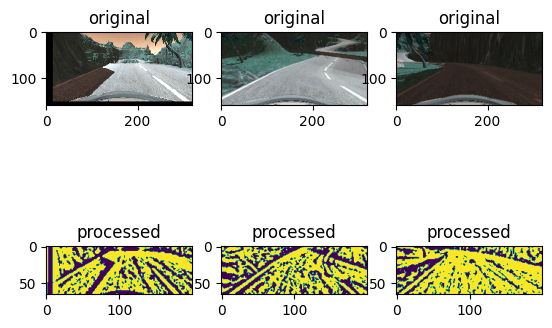

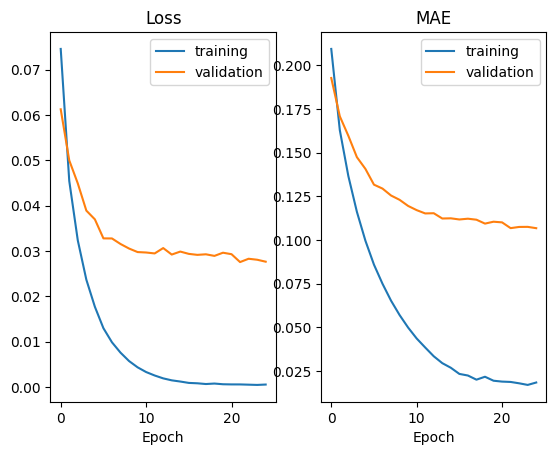

In [16]:
# adaptive thresholding
feat_image_list, feat_steering_list = image_preprocessing_feat(aug_image_list, aug_steering_list, True)
result_3 = run_training(feat_image_list, feat_steering_list, True)
print_training_result(result_3, True)

In [17]:
def feature_selection(img):
    img = img[60:135, :, :]  # Crop upper part
    # Resize the image to a consistent size
    img = cv2.resize(img, (200, 66))
    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply histogram equalization
    # equalized = cv2.equalizeHist(gray)
    blurred = cv2.GaussianBlur(gray, (3, 3), 0)
    # Apply adaptive thresholding to enhance lane visibility
    canny = cv2.Canny(blurred, 100, 300)
    # # Apply Gaussian blur to reduce noise
    # expand image dimension
    expand = np.expand_dims(canny, axis=2)
    # Normalize pixel values to [0, 1]
    normalized = expand / 255.0
    return normalized

-0.7180451 -0.3984962 -0.4022556
Training set size:  10452
Testing set size:  2613
Training size:  (66, 200, 1)
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 31, 98, 24)        624       
                                                                 
 conv2d_16 (Conv2D)          (None, 14, 47, 36)        21636     
                                                                 
 conv2d_17 (Conv2D)          (None, 5, 22, 48)         43248     
                                                                 
 conv2d_18 (Conv2D)          (None, 3, 20, 64)         27712     
                                                                 
 conv2d_19 (Conv2D)          (None, 1, 18, 64)         36928     
                                                                 
 flatten_3 (Flatten)         (None, 1152)              0         
        

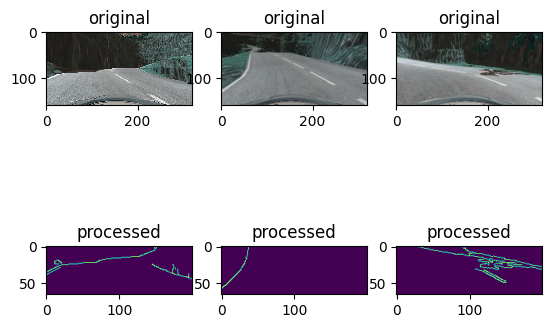

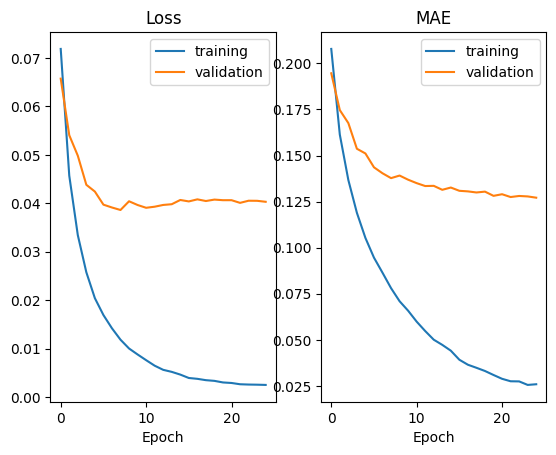

In [18]:
# canny edge
feat_image_list, feat_steering_list = image_preprocessing_feat(aug_image_list, aug_steering_list, True)
result_4 = run_training(feat_image_list, feat_steering_list, True)
print_training_result(result_4, True)

In [20]:
def feature_selection(image):
    image = image[60:135, :, :]  # Crop upper part
    # Resize the image to a consistent size
    image = cv2.resize(image, (200, 66))

    # Convert the image to the HSL color space
    hsl_image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)

    # Split the HSL image into H, L, and S channels
    h_channel, s_channel, l_channel = cv2.split(hsl_image)

    # Conditions
    # condition_1 = (100 < h_channel < 120) & (55 < s_channel < 80) & (25 < l_channel < 45)  Dark
    condition_1 = (90<h_channel)&(h_channel< 120) & ((s_channel-l_channel)>20) & ((s_channel-l_channel)<40) & (s_channel > 60)#(55<s_channel)&(s_channel<80) & (25<l_channel)&(l_channel<55)
    # condition_2 = (20 < h_channel < 40) & (s_channel > 200) | (l_channel > 200)   Bright
    condition_2 = (15<h_channel)&(h_channel<40) & ((((s_channel-l_channel)>175) & ((s_channel-l_channel)<220)) | ((s_channel>200)&(l_channel>100)))#| (l_channel > 220)

    # Create a binary mask by combining the two conditions using logical OR
    combined_mask = np.logical_or(condition_1, condition_2).astype(np.uint8) * 255

    # Convert the binary mask to 3 channels for merging with the original image
    binary_image = cv2.merge((combined_mask, combined_mask, combined_mask))

    # Reduce the saturation and lightness of original image
    s_channel = s_channel * 0.8
    l_channel = l_channel * 0.6


    reduced_image = cv2.merge((h_channel.astype(np.uint8), s_channel.astype(np.uint8), l_channel.astype(np.uint8)))

    # Apply bitwise_and to keep only the white lane lines
    white_lane_image = cv2.bitwise_or(reduced_image, binary_image)

    # Convert the image to grayscale
    gray = cv2.cvtColor(white_lane_image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # expand image dimension
    expand = np.expand_dims(blurred, axis=2)

    # Normalize pixel values to [0, 1]
    normalized = expand / 255.0

    return normalized

0.06015037 -0.9285714 0.07894737
Training set size:  10452
Testing set size:  2613
Training size:  (66, 200, 1)
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 17, 50, 16)        1040      
                                                                 
 conv2d_21 (Conv2D)          (None, 9, 25, 32)         12832     
                                                                 
 conv2d_22 (Conv2D)          (None, 5, 13, 64)         51264     
                                                                 
 flatten_4 (Flatten)         (None, 4160)              0         
                                                                 
 dense_16 (Dense)            (None, 512)               2130432   
                                                                 
 dropout (Dropout)           (None, 512)               0         
        

300/300 [==============================] - 115s 383ms/step - loss: 0.0763 - mae: 0.2115 - val_loss: 0.0655 - val_mae: 0.1932
Epoch 2/25
300/300 [==============================] - 113s 376ms/step - loss: 0.0592 - mae: 0.1848 - val_loss: 0.0624 - val_mae: 0.1871
Epoch 3/25
300/300 [==============================] - 113s 378ms/step - loss: 0.0541 - mae: 0.1753 - val_loss: 0.0572 - val_mae: 0.1784
Epoch 4/25
300/300 [==============================] - 114s 379ms/step - loss: 0.0509 - mae: 0.1700 - val_loss: 0.0567 - val_mae: 0.1772
Epoch 5/25
300/300 [==============================] - 114s 379ms/step - loss: 0.0481 - mae: 0.1648 - val_loss: 0.0541 - val_mae: 0.1727
Epoch 6/25
300/300 [==============================] - 113s 379ms/step - loss: 0.0466 - mae: 0.1623 - val_loss: 0.0544 - val_mae: 0.1735
Epoch 7/25
300/300 [==============================] - 114s 380ms/step - loss: 0.0438 - mae: 0.1575 - val_loss: 0.0543 - val_mae: 0.1720
Epoch 8/25
300/300 [==============================] - 114s 

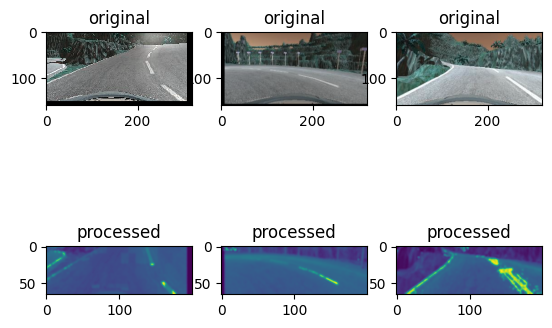

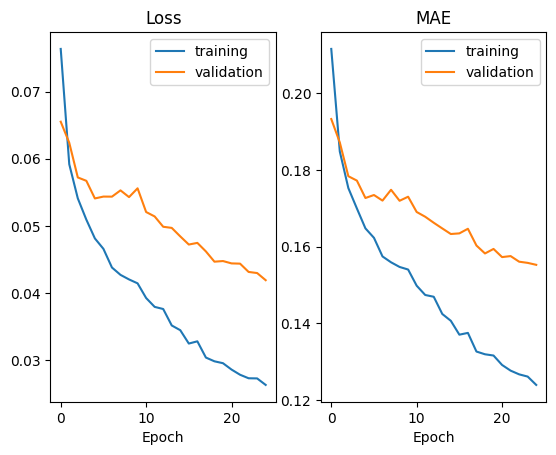

In [22]:
feat_image_list, feat_steering_list = image_preprocessing_feat(aug_image_list, aug_steering_list, True)
result_5 = run_training(feat_image_list, feat_steering_list, True, "comma_ai")
print_training_result(result_5, True)

In [19]:
# commai_model = create_comma_ai_model()
# commai_model.summary()

Model Deployment